# what_were_covering = {
    1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [39]:
import torch
from torch import nn 
import matplotlib.pyplot as plt 

torch.__version__

'2.5.0'

## 1. Data (preparing and loading)

- Let's create our data as a straight line.

- We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [40]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step)
y = weight * X + bias

X[:10], y[:10]

(tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
         0.1800]),
 tensor([0.3000, 0.3140, 0.3280, 0.3420, 0.3560, 0.3700, 0.3840, 0.3980, 0.4120,
         0.4260]))

### Split data into training and test sets
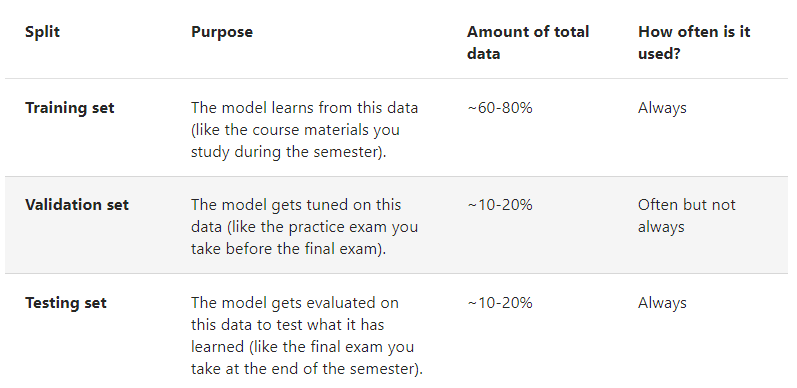

In [41]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

In [42]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

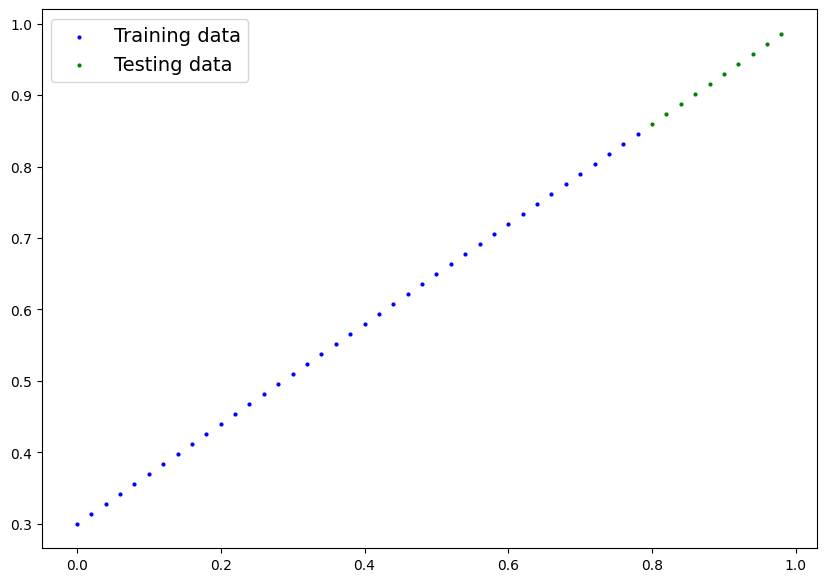

In [43]:
plot_predictions();

## 2. Building a model
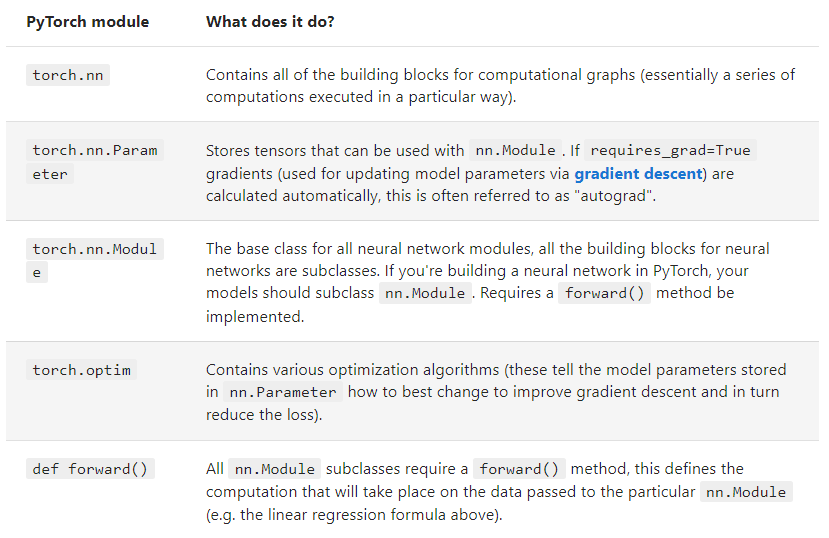

In [44]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

        self.bias = nn.Parameter(torch.randn(1, dtype=torch.float), requires_grad=True)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.weights * X + self.bias

* Model Parameters: state_dict() includes all parameters (weights and biases) and any other buffers (like running averages in batch normalization).
* Checkpointing: Saving the state dictionary is a standard way to save models during training so you can resume training or evaluate them later.
* Model Architecture: Remember that the architecture must be the same when loading the state dictionary. You need to create an instance of the model with the same structure.

### Checking the contents of a PyTorch model

In [45]:
## Instead of trainig we initialize some random values for the hyperparams
torch.manual_seed(42)

model_0 = LinearRegression()

list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [46]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making predictions using torch.inference_mode()

- As the name suggests, torch.inference_mode() is used when using a model for inference (making predictions).

- torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

In [47]:
with torch.inference_mode():
    y_preds = model_0(X_test)

In [48]:
# Check the predictions
print(f"Number of testing samples: {len(X_test)}") 
print(f"Number of predictions made: {len(y_preds)}")
print(f"Predicted values:\n{y_preds}")

Number of testing samples: 10
Number of predictions made: 10
Predicted values:
tensor([0.3982, 0.4049, 0.4116, 0.4184, 0.4251, 0.4318, 0.4386, 0.4453, 0.4520,
        0.4588])


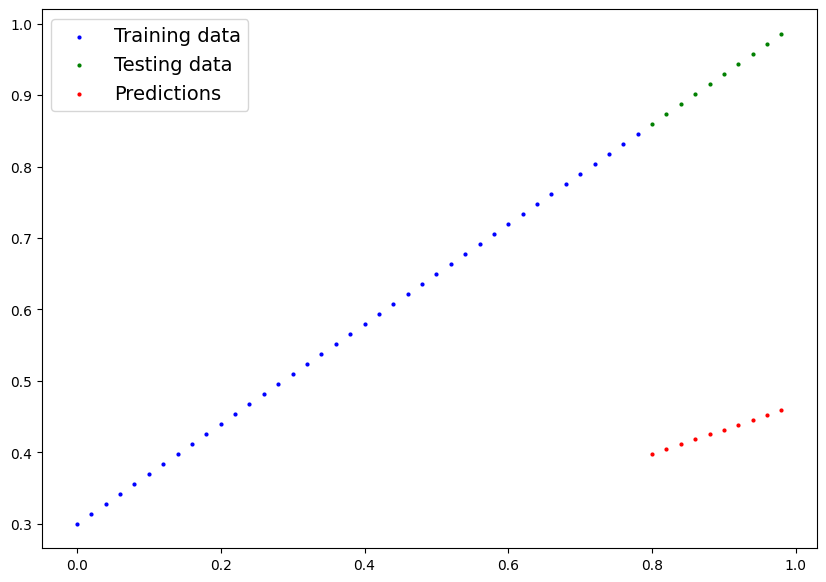

In [49]:
plot_predictions(predictions=y_preds)

In [50]:
y_test - y_preds

tensor([0.4618, 0.4691, 0.4764, 0.4836, 0.4909, 0.4982, 0.5054, 0.5127, 0.5200,
        0.5272])

- Those predictions look pretty bad...
- This make sense though when you remember our model is just using *random parameter values* to make predictions.


## 3. Train model
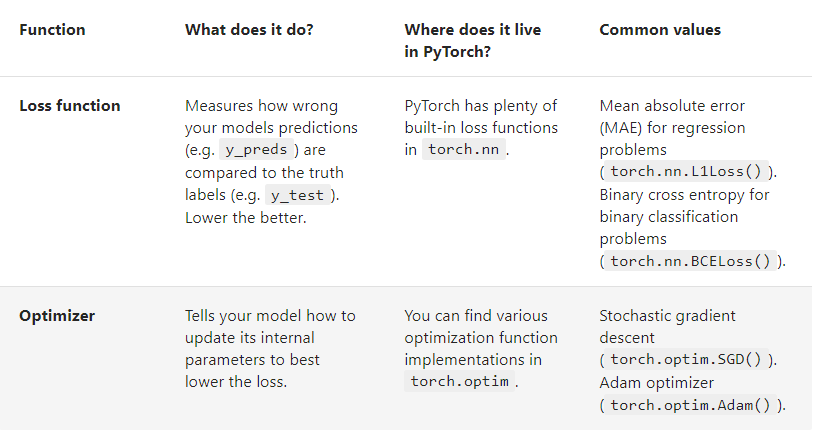
- Let's create a loss function and an optimizer we can use to help improve our model.

- Depending on what kind of problem you're working on will depend on what loss function and what optimizer you use.

- However, there are some common values, that are known to work well such as the SGD (stochastic gradient descent) or Adam optimizer. And the MAE (mean absolute error) loss function for regression problems (predicting a number) or binary cross entropy loss function for classification problems (predicting one thing or another).

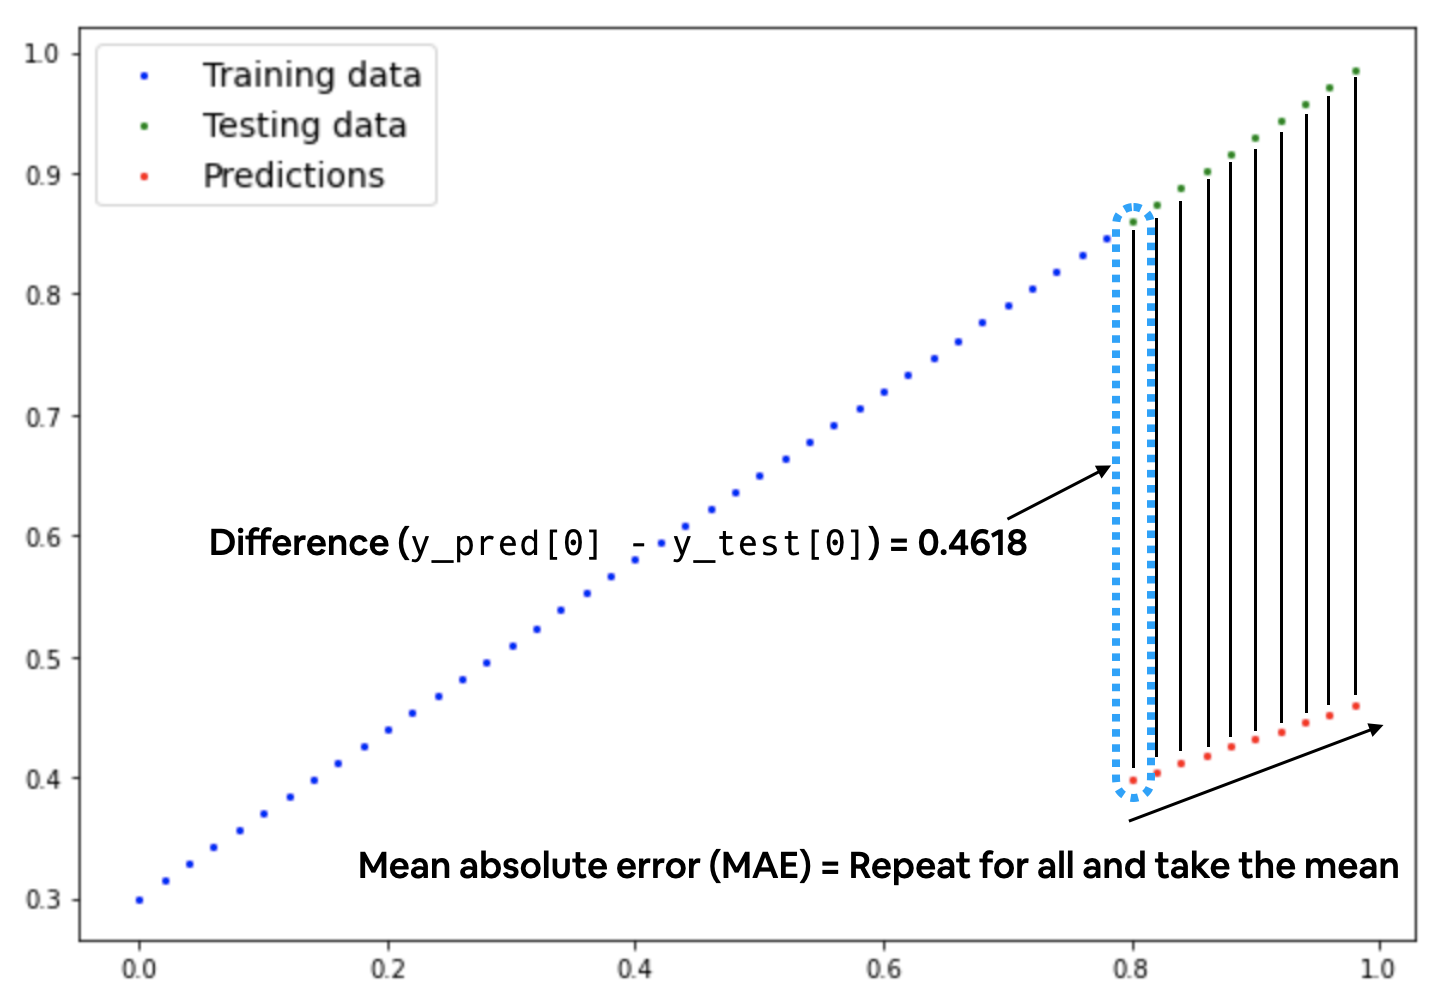

In [51]:
loss_fn = nn.L1Loss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.01)

## Creating the training loop
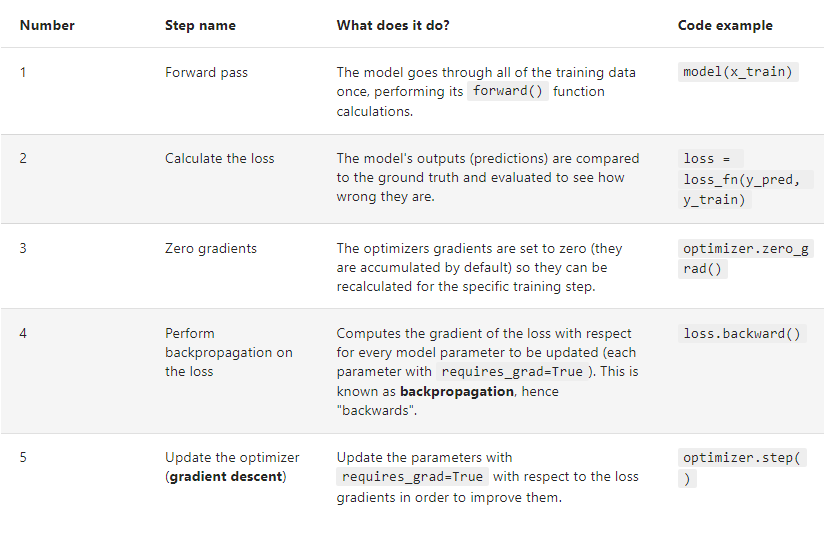

- Calculate the loss (loss = ...) before performing backpropagation on it (loss.backward()).
- Zero gradients (optimizer.zero_grad()) before stepping them (optimizer.step()).
- Step the optimizer (optimizer.step()) after performing backpropagation on the loss (loss.backward()).
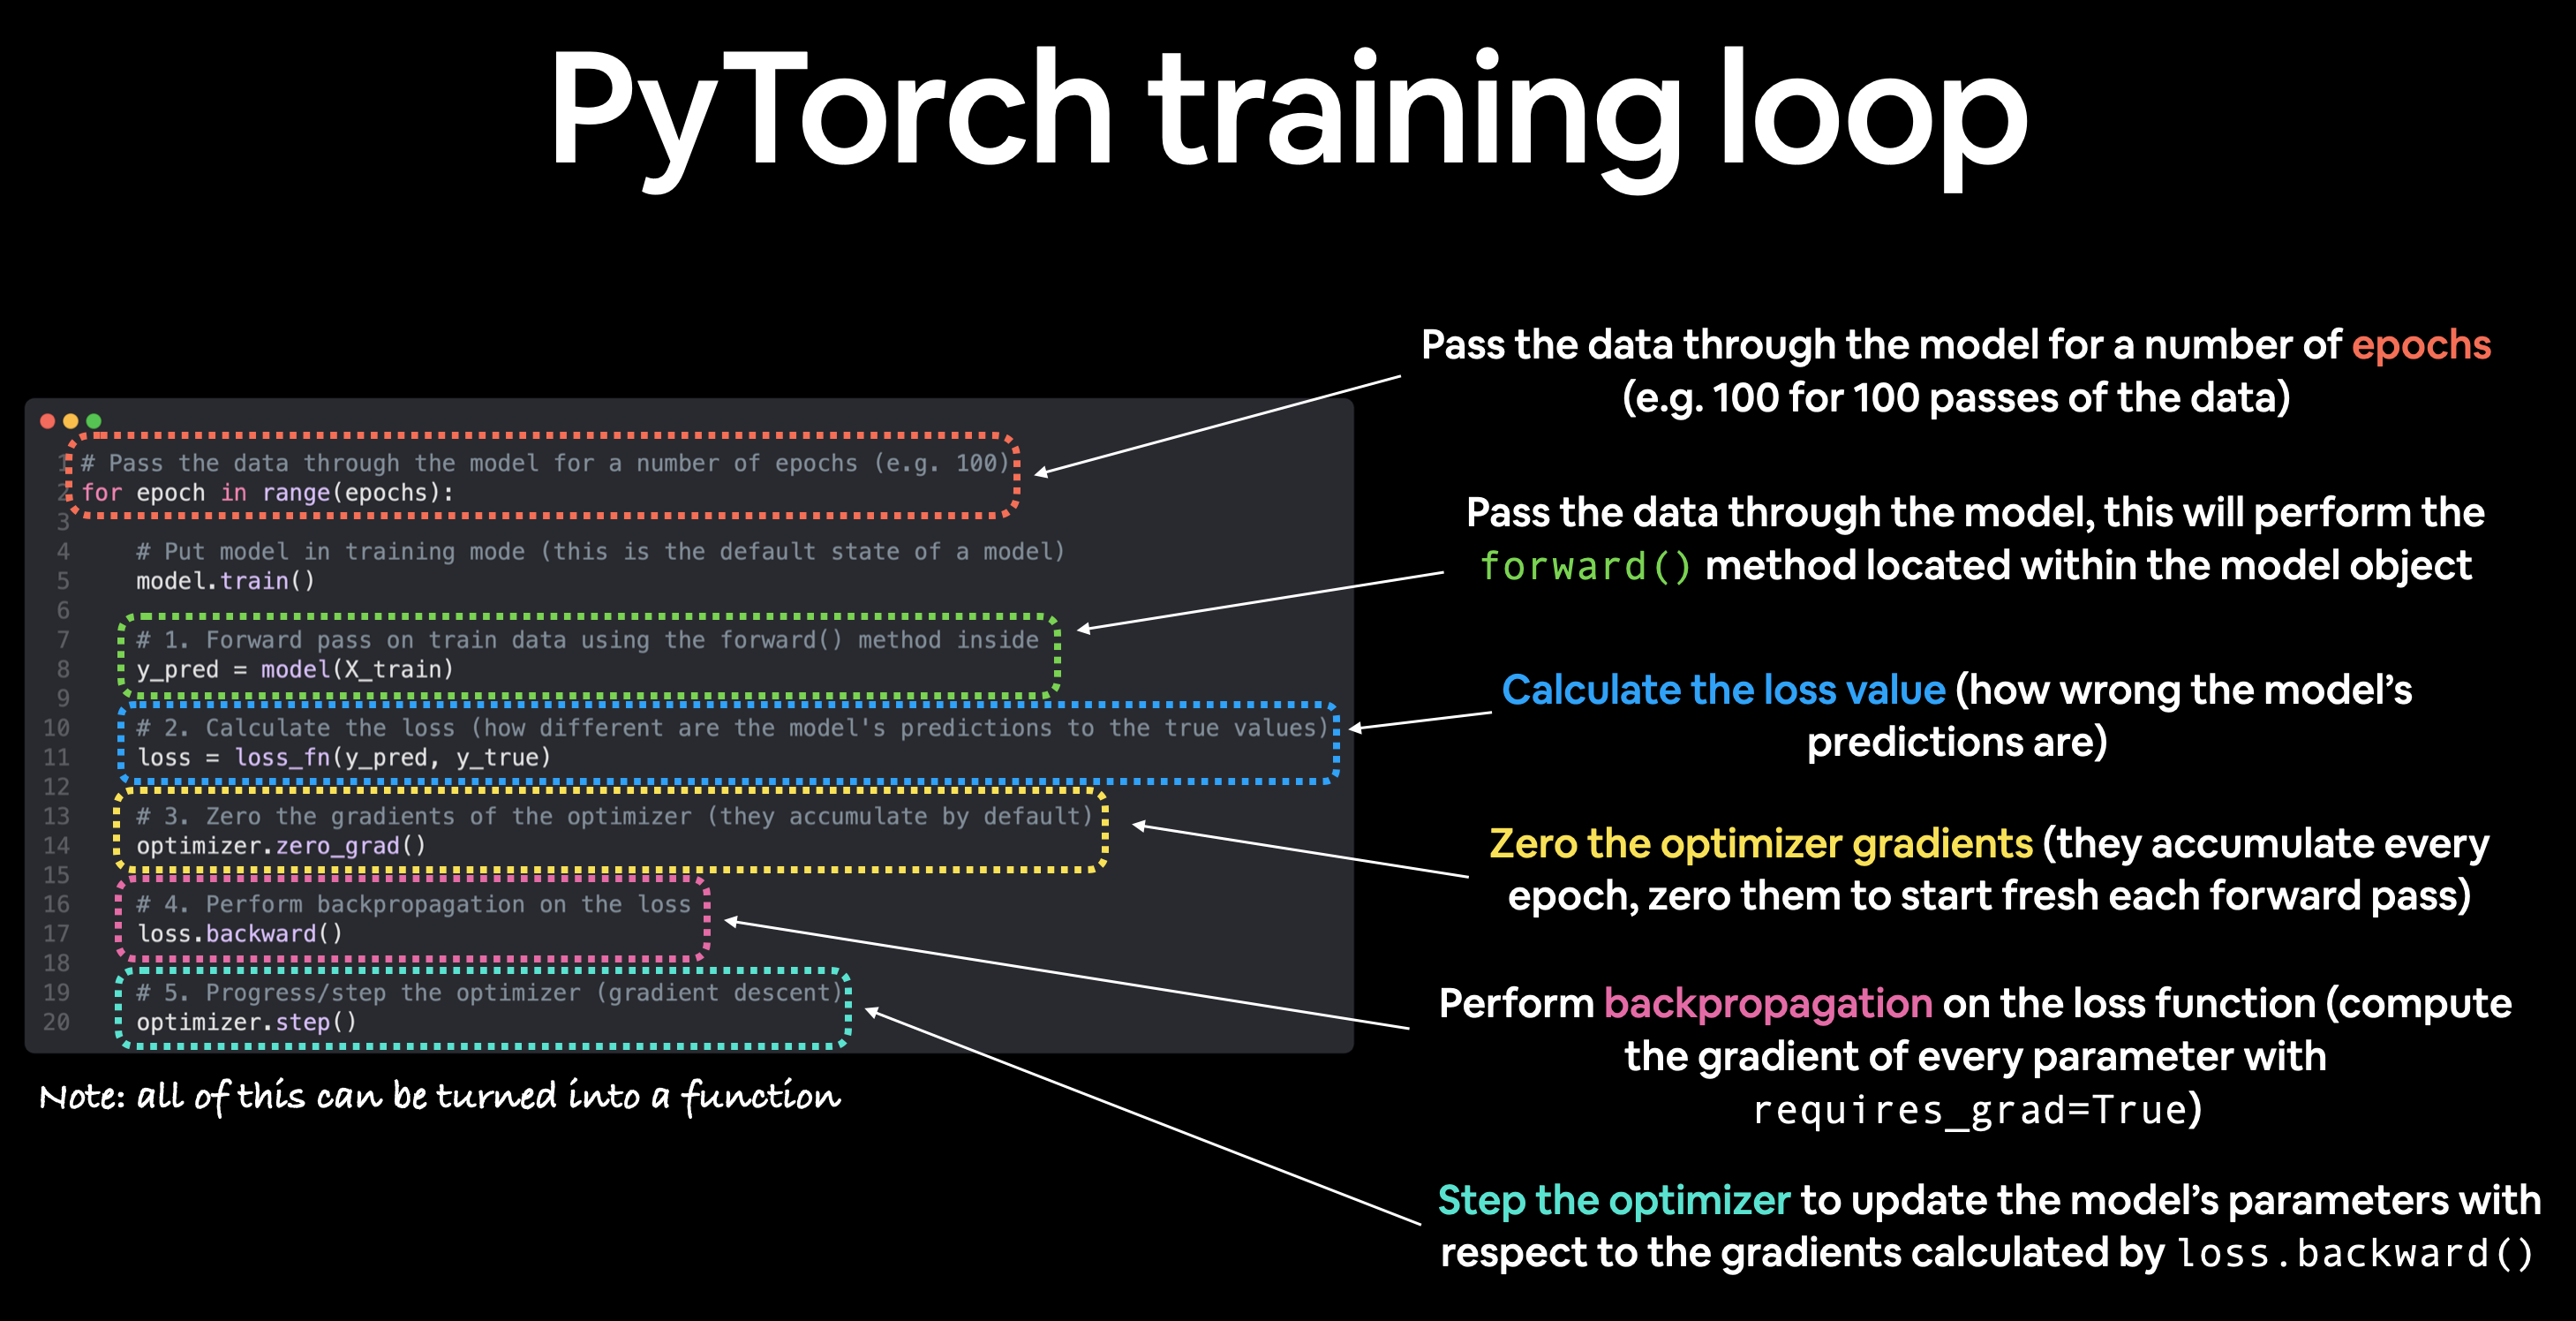

## Creating the testing loop
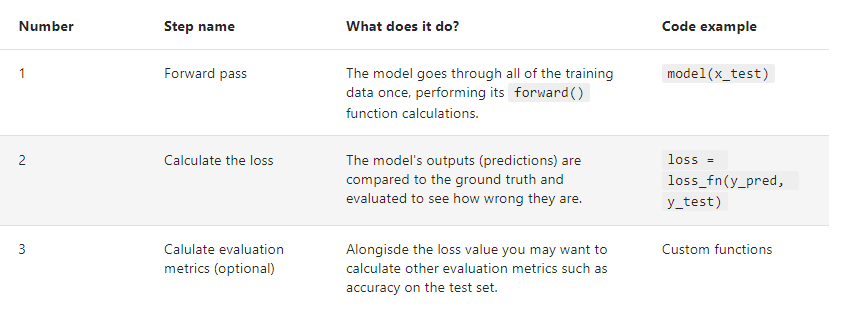
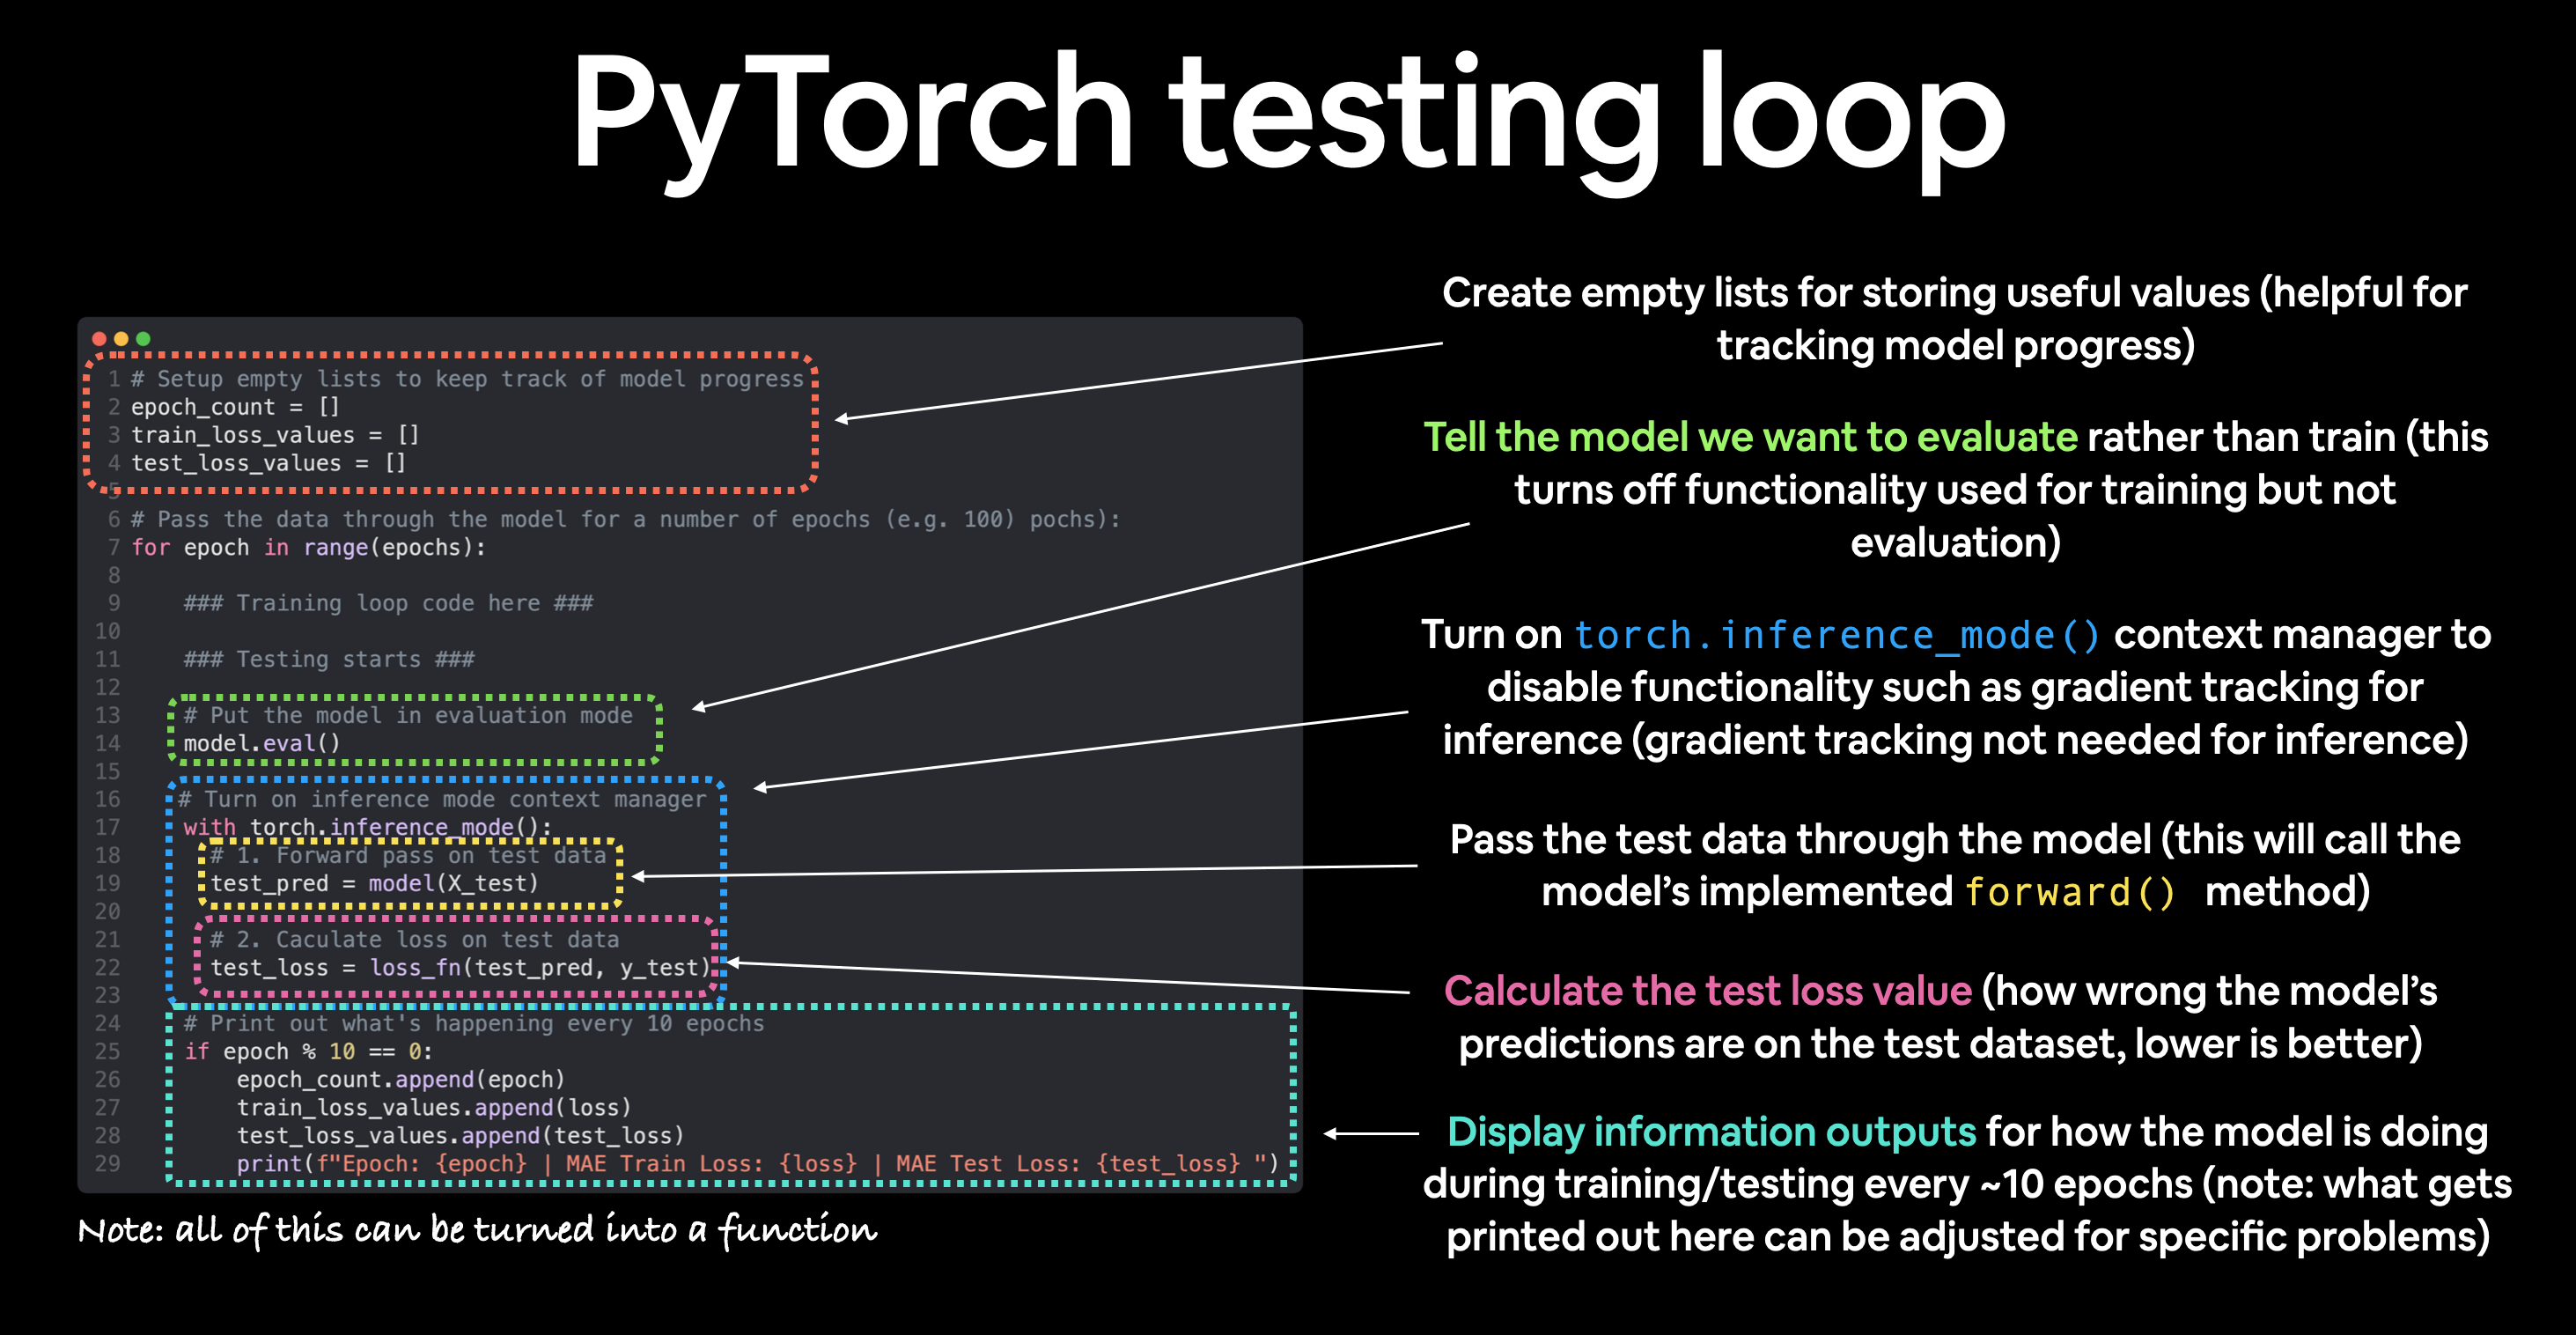

In [52]:
torch.manual_seed(42)

epochs = 100

train_loss_values = []
test_loss_values = []
epoch_count = []

for epoch in range(epochs):

    ## Set the training mode
    model_0.train()

    ## 1. Initializing the forward pass
    y_pred = model_0(X_train)

    ## 2. Calculate the loss (between predictions and ground truth)
    loss = loss_fn(y_pred, y_train)

    ## 3. Sets gradients of all model parameters to zero.
    optimizer.zero_grad()

    ## 4. Compute backward loss
    loss.backward()

    ## 5. Progress the Optimizer moving forward
    optimizer.step()

    ## Testing Part
    model_0.eval()

    with torch.inference_mode():
        test_pred = model_0(X_test)

        test_loss = loss_fn(test_pred, y_test.type(torch.float))

        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss}")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819


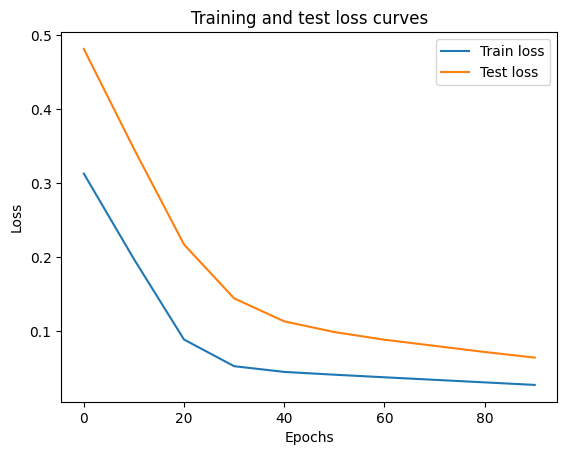

In [53]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

In [54]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.5784])), ('bias', tensor([0.3513]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


- This is the whole idea of machine learning and deep learning, **there are some ideal values that describe our data** and rather than figuring them out by hand, **we can train a model to figure them out programmatically.**

## 4. Making predictions with a trained PyTorch model (inference)
- Once you've trained a model, you'll likely want to make predictions with it.

- We've already seen a glimpse of this in the training and testing code above, the steps to do it outside of the training/testing loop are similar.

There are three things to remember when making predictions (also called performing inference) with a PyTorch model:

- Set the model in evaluation mode (model.eval()).
- Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
- All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [55]:
model_0.eval()

with torch.inference_mode():
    y_preds = model_0(X_test)

y_preds

tensor([0.8141, 0.8256, 0.8372, 0.8488, 0.8603, 0.8719, 0.8835, 0.8950, 0.9066,
        0.9182])

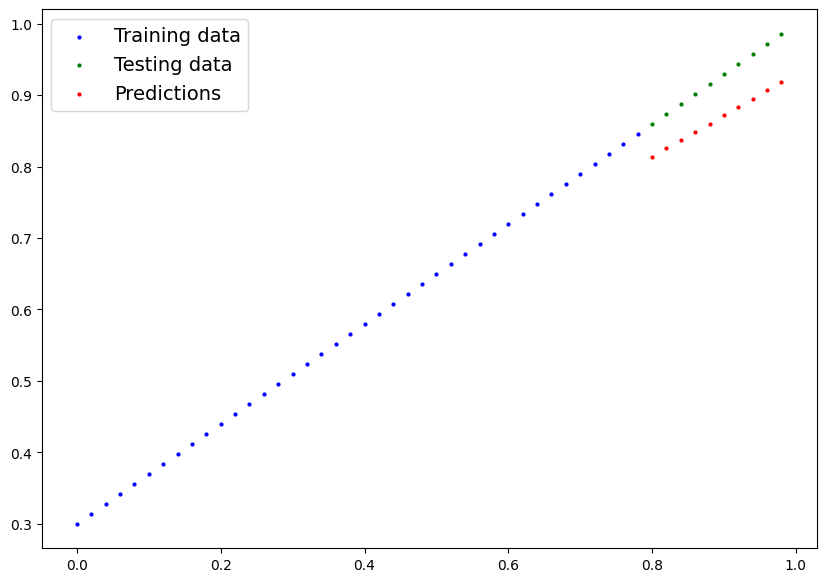

In [56]:
plot_predictions(predictions=y_preds)

## 5. Saving and loading a PyTorch model
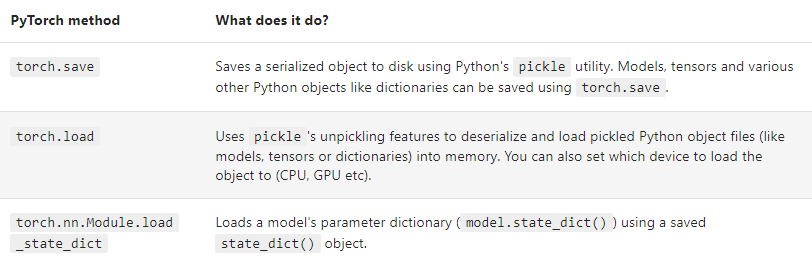


### Saving a PyTorch model's state_dict()
The recommended way for saving and loading a model for inference (making predictions) is by saving and loading a model's state_dict().

Let's see how we can do that in a few steps:

- We'll create a directory for saving models to called models using Python's pathlib module.
- We'll create a file path to save the model to.
- We'll call torch.save(obj, f) where obj is the target model's state_dict() and f is the filename of where to save the model.

In [57]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models\01_pytorch_workflow_model_0.pth


In [58]:
## Checking if the model is saved inside the folder
!dir models

 Volume in drive E is New Volume
 Volume Serial Number is B4DD-E62C

 Directory of e:\Torch Learning\models

02-08-2024  15:08    <DIR>          .
02-08-2024  15:08    <DIR>          ..
24-10-2024  09:43             1,680 01_pytorch_workflow_model_0.pth
               1 File(s)          1,680 bytes
               2 Dir(s)  974,998,786,048 bytes free


## Loading a saved PyTorch model's state_dict()

- Loading the saved model requires two important components which are
    - Creating a new instance of the model architecture.
    - The saved model weights

In [59]:
loaded_model = LinearRegression()

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

C:\Users\Administrator\AppData\Local\Temp\ipykernel_16968\737136270.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_

<All keys matched successfully>

In [60]:
# 1. Put the loaded model into evaluation mode
loaded_model.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test) # perform a forward pass on the test data with the loaded model

In [61]:
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([True, True, True, True, True, True, True, True, True, True])